# Structure Function Turbulent Data

In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import numpy as np

import torch
from turboflow.models.rff import RFFNet
from turboflow.dataloaders import Turbo2D_simple, load_turbo2D_simple_numpy
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

# set up cuda 
torch.cuda.is_available()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [3]:
# ds=downsampling factor
Xlr, Ulr = load_turbo2D_simple_numpy(ds=4) # low resolution (64x64)
Xmr, Umr = load_turbo2D_simple_numpy(ds=2) # mid resolution (128x128)
Xhr, Uhr = load_turbo2D_simple_numpy(ds=1) # high (max) resolution (256x256)

L = int(Xlr.shape[0]**0.5)
M = int(Xmr.shape[0]**0.5)
H = int(Xhr.shape[0]**0.5)

Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0
Y shape (128, 128, 2)
Y min, max: -2.371183 2.985797
after normalization, Y min, max: -0.7941541236728418 1.0
Y shape (256, 256, 2)
Y min, max: -2.382122 2.999472
after normalization, Y min, max: -0.7941804424245333 1.0


In [4]:
from turboflow.models.rff import RFFNet

# model (RFF + MLP)
fft_scale = 10
fft_nfeat = 256
nin = 2  # = x and y coordinates
nout = 2 # = ux and uy components
mlp_layers = [nin*fft_nfeat] + [256]*3 + [nout]

rffnet = RFFNet('RFFNet', mlp_layers, fft_nfeat, fft_scale)

# training data
path_to_data = '../data/2021-Turb2D_velocities.npy'
trainset = Turbo2D_simple(path_to_data, device, ds=4, img=42)
trainloader = DataLoader(trainset, batch_size=6666, shuffle=False)

# TRAIN!
rffnet.to(device)
rffnet.fit(trainloader, epochs=2000) # we are not afraid to overfit the data, this is coord-based MLP!

Dataset Turbo2D, img # 42
(64, 64, 2)
(64, 64, 2)
Original size 64
Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0
Epoch: 100, Loss: 0.001660
Epoch: 200, Loss: 0.000026
Epoch: 300, Loss: 0.000003
Epoch: 400, Loss: 0.000001
Epoch: 500, Loss: 0.000001
Epoch: 600, Loss: 0.000001
Epoch: 700, Loss: 0.000001
Epoch: 800, Loss: 0.000000
Epoch: 900, Loss: 0.000000
Epoch: 1000, Loss: 0.000000
Epoch: 1100, Loss: 0.000000
Epoch: 1200, Loss: 0.000000
Epoch: 1300, Loss: 0.000044
Epoch: 1400, Loss: 0.000000
Epoch: 1500, Loss: 0.000002
Epoch: 1600, Loss: 0.000000
Epoch: 1700, Loss: 0.000003
Epoch: 1800, Loss: 0.000000
Epoch: 1900, Loss: 0.000000
Epoch: 2000, Loss: 0.000000
Done with Training
Final error: 1.3407009191723773e-06


In [5]:
from turboflow.models.phyrff_soft import PiRFFNet

# model (RFF + MLP)
fft_scale = 10
fft_nfeat = 256
nin = 2
nout = 2
mlp_layers = [nin*fft_nfeat] + [256]*3 + [nout]

pirffntet = PiRFFNet('PIRFFNet', mlp_layers, fft_nfeat, fft_scale)

# training data
path_to_data = '../data/2021-Turb2D_velocities.npy'
trainset = Turbo2D_simple(path_to_data, device, img=42)
trainloader = DataLoader(trainset, batch_size=6666, shuffle=False)

# TRAIN!
pirffntet.to(device)
pirffntet.fit(trainloader, epochs=2000)

Dataset Turbo2D, img # 42
(64, 64, 2)
(64, 64, 2)
Original size 64
Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0
Epoch: 100, Loss: (0.020192 + 117.915199) = 0.031984
Epoch: 200, Loss: (0.002556 + 79.753006) = 0.010532
Epoch: 300, Loss: (0.001088 + 66.186874) = 0.007706
Epoch: 400, Loss: (0.000733 + 57.417961) = 0.006474
Epoch: 500, Loss: (0.000571 + 53.622913) = 0.005933
Epoch: 600, Loss: (0.000458 + 48.016010) = 0.005259
Epoch: 700, Loss: (0.000378 + 44.646893) = 0.004842
Epoch: 800, Loss: (0.000354 + 40.961964) = 0.004450
Epoch: 900, Loss: (0.000299 + 37.808651) = 0.004080
Epoch: 1000, Loss: (0.000259 + 36.668083) = 0.003926
Epoch: 1100, Loss: (0.000252 + 35.441628) = 0.003796
Epoch: 1200, Loss: (0.000228 + 32.664799) = 0.003494
Epoch: 1300, Loss: (0.000208 + 30.260942) = 0.003234
Epoch: 1400, Loss: (0.000199 + 29.198399) = 0.003119
Epoch: 1500, Loss: (0.000183 + 27.346107) = 0.002917
Epoch: 1600, Loss: (0.000175 + 27.9225

In [7]:
# training data
path_to_data = '../data/2021-Turb2D_velocities.npy'
trainset = Turbo2D_simple(path_to_data, device, ds=4, img=42)
trainloader = DataLoader(trainset, batch_size=6666, shuffle=False)

X, y = trainset[:5]
delta_x = (X[2,1] - X[1,1]).item()
smallest_increment = delta_x/4

Dataset Turbo2D, img # 42
(64, 64, 2)
(64, 64, 2)
Original size 64
Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0


In [8]:
from turboflow.models.phyrff_sfun import SfunRFFNet

# model (RFF + MLP)
fft_scale = 10
fft_nfeat = 256
nin = 2  # = x and y coordinates
nout = 2 # = ux and uy components
mlp_layers = [nin*fft_nfeat] + [256]*3 + [nout]

# model
sfunrffnet = SfunRFFNet('SfunRFFNet', mlp_layers, fft_nfeat, fft_scale,
                    smallest_increment = smallest_increment, n_centers=10)

sfunrffnet.to(device)
sfunrffnet.fit(trainloader, epochs=6000) # we are not afraid to overfit the data, this is coord-based MLP!

Epoch: 100, Loss: (0.048679 + 0.008040 + 0.016302) = 0.073021
Epoch: 200, Loss: (0.022099 + 0.004528 + 0.009039) = 0.035666
Epoch: 300, Loss: (0.007088 + 0.003515 + 0.007168) = 0.017771
Epoch: 400, Loss: (0.003551 + 0.003205 + 0.006409) = 0.013165
Epoch: 500, Loss: (0.002525 + 0.002099 + 0.005962) = 0.010586
Epoch: 600, Loss: (0.001893 + 0.002153 + 0.005791) = 0.009837
Epoch: 700, Loss: (0.001666 + 0.002301 + 0.005221) = 0.009189
Epoch: 800, Loss: (0.001467 + 0.002853 + 0.005494) = 0.009814
Epoch: 900, Loss: (0.001643 + 0.005373 + 0.004858) = 0.011874
Epoch: 1000, Loss: (0.001401 + 0.001680 + 0.004948) = 0.008029
Epoch: 1100, Loss: (0.001165 + 0.005815 + 0.004939) = 0.011920
Epoch: 1200, Loss: (0.001304 + 0.002363 + 0.004695) = 0.008362
Epoch: 1300, Loss: (0.001235 + 0.003183 + 0.004321) = 0.008740
Epoch: 1400, Loss: (0.001363 + 0.001384 + 0.004342) = 0.007090
Epoch: 1500, Loss: (0.001239 + 0.004673 + 0.003996) = 0.009908
Epoch: 1600, Loss: (0.001319 + 0.001713 + 0.004114) = 0.007146
E

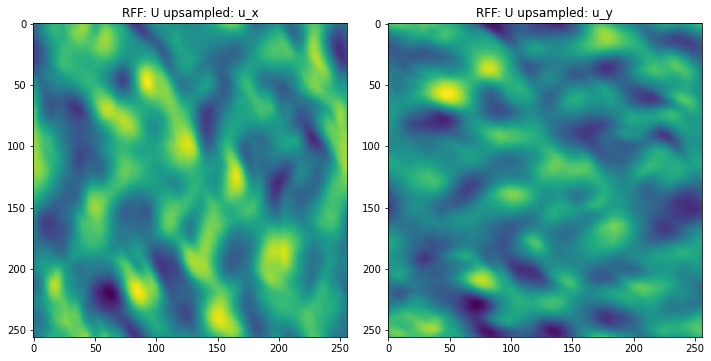

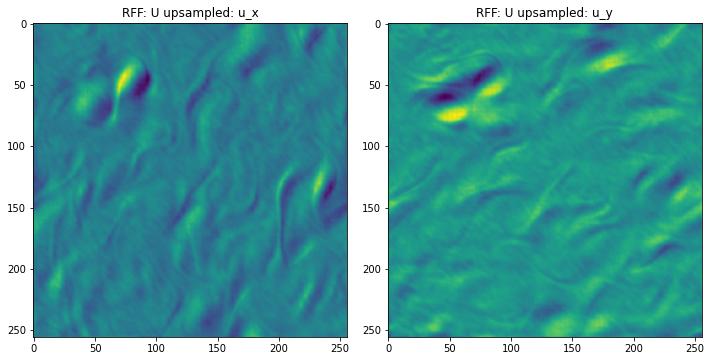

In [9]:
x = torch.from_numpy(Xhr).float().contiguous().to(device)

sfunrffnet.eval().to(device)
pred = sfunrffnet(x)
Udfphy = pred.cpu().detach().numpy().squeeze().reshape(H,H,2)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('RFF: U upsampled: u_x')
plt.imshow(Udfphy[:,:,0])
plt.subplot(122)
plt.title('RFF: U upsampled: u_y')
plt.imshow(Udfphy[:,:,1])
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('Error Ux')
plt.imshow(Udfphy[:,:,0] - Uhr.reshape(H,H,2)[:,:,0])
plt.subplot(122)
plt.title('Error Uy')
plt.imshow(Udfphy[:,:,1] - Uhr.reshape(H,H,2)[:,:,1])
plt.tight_layout()
plt.show()

In [15]:
x = torch.from_numpy(Xhr).float().contiguous().to(device)

Upde = pirffntet(x).cpu().detach().numpy().squeeze()
Usfun = sfunrffnet(x).cpu().detach().numpy().squeeze()
Urff = rffnet(x).cpu().detach().numpy().squeeze()

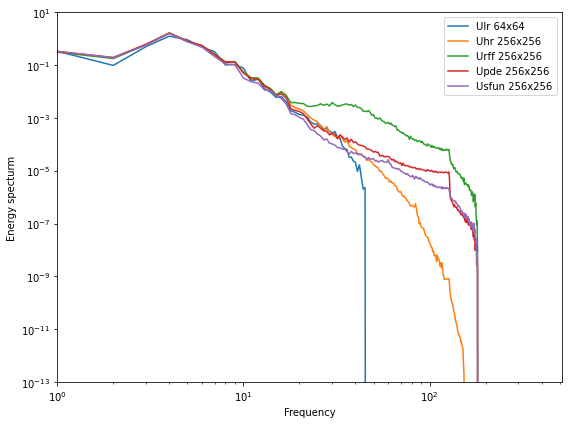

In [16]:
from turboflow.utils import phy_utils as phy

fig, axs = plt.subplots(1,1,figsize=(8,6))
axs.loglog(np.arange(len(phy.powerspec(Ulr.reshape(L,L,2)[:,:,1]))), 
                         phy.powerspec(Ulr.reshape(L,L,2)[:,:,1]), label='Ulr 64x64')
axs.loglog(np.arange(len(phy.powerspec(Uhr.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Uhr.reshape(H,H,2)[:,:,0]), label='Uhr 256x256')
axs.loglog(np.arange(len(phy.powerspec(Urff.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Urff.reshape(H,H,2)[:,:,0]), label='Urff 256x256')
axs.loglog(np.arange(len(phy.powerspec(Upde.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Upde.reshape(H,H,2)[:,:,0]), label='Upde 256x256')
axs.loglog(np.arange(len(phy.powerspec(Usfun.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Usfun.reshape(H,H,2)[:,:,0]), label='Usfun 256x256')
axs.set_ylim(10**(-13), 10)
axs.set_xlim(1, 512)
axs.legend()
plt.ylabel('Energy specturm')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

(65536, 2)


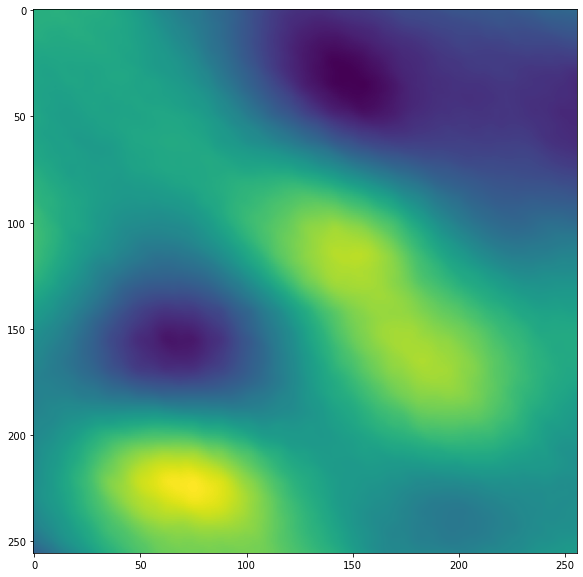

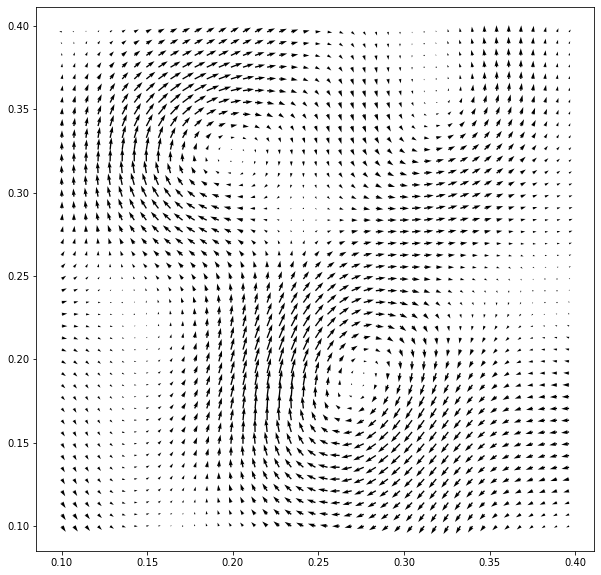

In [17]:
# Let s zoom in it!
ngrid = 256
coords = np.linspace(0.1, 0.4, ngrid)
coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
coords = coords.reshape(ngrid*ngrid,2)
print(coords.shape)

x = torch.from_numpy(coords).float().contiguous().to(device)

sfunrffnet.eval().to(device)
pred = sfunrffnet(x)
pred = pred.cpu().detach().numpy().squeeze().reshape(ngrid,ngrid,2)

plt.figure(figsize=(10,10))
plt.imshow(pred[:,:,0])
plt.show()

s = 6
plt.figure(figsize=(10,10))
plt.quiver(coords.reshape(ngrid,ngrid,2)[::s,::s,0],
           coords.reshape(ngrid,ngrid,2)[::s,::s,1],
           pred[::s,::s,0],pred[::s,::s,1])